Weiyu Wang (ww2508)  
Hsiao-Yuan Lin (hl3204)  
Link to Google Colaboratory: https://colab.research.google.com/drive/10N_V3xANxD8P3ttWQFRtZfAnuEnqM4HS#scrollTo=zxxFEYkn7ko0

# 1. Fully Connected Network from Scratch


## 1.1 Loading the CIFAR10 Dataset

In [0]:
import numpy as np
def softmaxAL(X):
    #print('softmax input', X)
    shiftx = X - np.max(X)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

In [0]:
import torch, torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
c, l, w = trainset[0][0].shape
n_train, n_test = len(trainset), len(testset)

X_train, X_test = np.zeros([n_train, c * l * w]), np.zeros([n_test, c * l * w])
y_train, y_test = np.zeros([n_train]), np.zeros([n_test])

for i in range(n_train):
    X_train[i] = trainset[i][0].numpy().flatten()
    y_train[i] = trainset[i][1]
  
for i in range(n_test):
    X_test[i] = testset[i][0].numpy().flatten()
    y_test[i] = testset[i][1]

y_train, y_test = y_train.astype(int), y_test.astype(int)

In [0]:
ind = np.random.permutation(len(X_train))
X_train, y_train = X_train[ind], y_train[ind]

# split training/validation dataset
validation_split = 0.1
n_train = int(X_train.shape[0]*(1-validation_split))
X_train, X_valid = X_train[:n_train], X_train[n_train:]
y_train, y_valid = y_train[:n_train], y_train[n_train:]

## 1.2 Implementing the Network

In [0]:
#@title
class NeuralNetwork:
    #layer_dimensions: a list, i-th element in the list represents num of units in i-th layer
    def __init__(self, layer_dimensions):
        self.layer_dimensions = layer_dimensions
        self.W = []
        self.b = []
        #W, b are matrix
        #W[i]: i-th layer
        #initialize weights and bias
        for i in range(1, len(self.layer_dimensions)):
            eps = np.sqrt(2.0/(self.layer_dimensions[i] + self.layer_dimensions[i-1]))
            W_i = np.random.randn(self.layer_dimensions[i], self.layer_dimensions[i-1]) * eps
            self.W.append(W_i)
            b_i = np.zeros((self.layer_dimensions[i], 1)) + 0.01
            b_i = b_i.reshape((b_i.shape[0], 1))
            self.b.append(b_i)
        
    def affineForward(self, A, W, b):
        # print(A.shape)
        tmp = np.matmul(W, A)
        tmp = tmp.reshape((tmp.shape[0], 1))
        result = np.add(tmp, b)
        return result
    
    def activationForward(self, A):
        return np.maximum(0, A)
    
    def forwardPropagation(self, X):
        #call affineForward
        batch_size = X.shape[0]
        #print('bs', batch_size)
        a_matrix = np.zeros((batch_size, self.layer_dimensions[-1]))
        cache_matrix = []
        for idx, one_x in enumerate(X):    
          # final A should be a matrix: 一个batch里的所有sample的aL叠在一起
          #feedforward
          cache = [(one_x, one_x)]
          a = one_x
          #print(one_x[0])
          for i in range(len(self.layer_dimensions)-2):
              z_i = self.affineForward(a, self.W[i], self.b[i])
              #print(z_i[0])
              a_i = self.activationForward(z_i)
              cache.append((z_i, a_i))
              a = a_i
          z_i = self.affineForward(a, self.W[-1], self.b[-1])
          # print(z_i[0])
          a_i = softmaxAL(z_i)
          cache.append((z_i, a_i))
          a = a_i
          a_matrix[idx] = np.reshape(a, (a.shape[0]))
          cache_matrix.append(cache)
        
        a_matrix = np.asarray(a_matrix)
        cache_matrix = np.asarray(cache_matrix)
        return a_matrix, cache_matrix
        
    def costFunction(self, AL, y):
        # AL: after softmax
        m = y.shape[0]
        correct_label_prob = AL[range(m), y]
        
        cost = -np.sum(np.log(correct_label_prob)) / m
        return cost
    
    def affineBackward(self, dA_prev, cache):
        # dA_prev: specify the layer(e.g. dA_prev = 2)
        # calculate dZ3/dA2 = W3, W3=W[2]
        return self.W[dA_prev]
        
    def activationBackward(self, dA, cache):
        # take the derivative of dA_l w.r.t. z_l, A_l = g(z_l), g: ReLU
        # in cache: z_l
        # dA: specify the layer(e.g. dA = 2)
        
        # Note: cache[dA][0] could actually be a matrix of 0 and 1
        z_l = [cache[i][dA][0] for i in range(cache.shape[0])]
        result = np.zeros([len(z_l), len(z_l[0])])
        # result =[[0 for i in range(len(z_l[0]))] for j in range(len(z_l))]
        for i in range(len(z_l)):
          for j in range(len(z_l[0])):
            if z_l[i][j] > 0:
              result[i][j] = 1
        # result = np.asarray(result)
        return result

      
    def backPropagation(self, dAL, Y, cache):
        # L means the last layer
        # Y: the correct labels, the shape is 100x1(if bath size is 100)
        # dAL: the activation of the last layer, should be size 100x10 nparray
        # return: gradients [(dW3, db3), (dW2, db2), (dW1, db1)]
        
        # For the last layer especially
        # suppose 3 is the last layer
        # dL/dW3 = dL/dZ3*dZ3/dW3

        #convert Y to matrix of indicator vectors(size 100x10)
        Y_iv = []
        for i in range(Y.shape[0]):
            tmp = [0 for i in range(self.layer_dimensions[-1])]
            tmp[int(Y[i])] = 1
            Y_iv.append(tmp)
        Y_iv = np.asarray(Y_iv)
        
        gradients = []
        #print('dAL', dAL)
        # compute dL/dZ3, dL/dZL=dL/dAL*dAL/dZL cross entropy+softmax can be computed together:
        # dL_dzl = np.subtract(dAL, Y_iv)
        #print('dAL shape', dAL.shape)
        dL_dzl = dAL.T - Y_iv.T
        #print('dL_dzl shape', dL_dzl.shape)
        # dL/dW3 = dL/dZ3*dZ3/dW3 = dL/dZ3* A2
        A_prev = [cache[i][-2][1] for i in range(cache.shape[0])]
        A_prev = np.asarray(A_prev)
        A_prev = np.reshape(A_prev, (A_prev.shape[0], A_prev.shape[1]))

        dL_dWl = np.matmul(dL_dzl, A_prev)
        # dL/db3 = dL/dZ3*dZ3/db3 = dL/dZ3
        # print("dL_dW2:", dL_dWl)
        # get the avg of dZ3, as a column
        dL_dzl_avg = dL_dzl.sum(axis=1)/dL_dzl.shape[1]
        dL_dbl = dL_dzl_avg
        dL_dbl = dL_dbl.reshape((dL_dbl.shape[0], 1))
        
        gradients.append((dL_dWl, dL_dbl))
        
        dL_dzpost = dL_dzl
        # start from the second last layer:
        for i in range(len(self.layer_dimensions)-2, 0, -1):
          # compute dL/dW2 = dL/dZ3*dZ3/dA2*dA2/dZ2*dZ2/dW2(A1)
          # affineBackward: calculate dZ3/dA2
          dZpost_dAi = self.affineBackward(i, cache)
          # activationBackward: calculate dA2/dZ2
          dAi_dZi = self.activationBackward(i, cache)
          # dZ2/dW2 = A1
          
          
          A_prev = [cache[j][i-1][1] for j in range(cache.shape[0])]
          A_prev = np.asarray(A_prev)
          A_prev = np.reshape(A_prev, (A_prev.shape[0], A_prev.shape[1]))
 
          
          dZi_dWi = A_prev
          

          #dL_dZi = dL_dzpost*dZpost_dAi*dAi_dZi
          
          tmp = np.matmul(np.transpose(dL_dzpost), dZpost_dAi)
          dL_dZi = tmp * dAi_dZi
        
          dL_dZi = np.transpose(dL_dZi)
          dL_dzpost = dL_dZi
          
          
          
          # dL_dWi = dL_dZi*dZi_dWi
          
          dL_dWi = np.matmul(dL_dZi, dZi_dWi)
          
          #print(dL_dWi.shape)

          #dL/db2 = dL/dZ2*dZ3/db2 = dL/dZ2
          
          
          dL_dzi_avg = dL_dZi.sum(axis=1)/dL_dZi.shape[1]
          dL_dbi = dL_dzi_avg
          dL_dbi = dL_dbi.reshape((dL_dbi.shape[0], 1))

          gradients.append((dL_dWi, dL_dbi))
        
        return gradients
                
      
    def updateParameters(self, gradients, alpha):
        # gradients:[(dW3, db3), (dW2, db2), (dW1, db1)]
        gradients = gradients[::-1]
#         print("max(self.W[0])")
#         print(np.amax(self.W[0]))
        for i in range(len(gradients)):
          self.W[i] = self.W[i] - alpha*gradients[i][0]
          self.b[i] = self.b[i] - alpha*gradients[i][1]
#           print(self.b[i].shape)
        
        
    def predict(self, X_new): 
        predict_results = []
        last_activations,_ = self.forwardPropagation(X_new)
        for i in range(last_activations.shape[0]):
          output = softmaxAL(last_activations[i])
          (val, idx) = max((v, i) for i, v in enumerate(output))
          predict_results.append(idx)
        return predict_results

      
      
    def train(self, X_train, X_val, y_train, y_val, iters, alpha, batch_size):
     
        #feedward -> costfunction -> backpropagation(affinebackward, activationbackward) -> return gradient -> updateParameters
          
        n_batch = int(np.ceil(X_train.shape[0]/batch_size))
        for epoch in range(iters):
#           print("self.W[0][0]")
#           print(self.W[0][0])
#           print("self.b[0][0]")
#           print(self.b[0][0])
          loss = 0
          correct = 0
          for idx in range(n_batch):
            # print("current batch:", idx)
            start_idx = idx*batch_size
            end_idx = min(X_train.shape[0], start_idx+batch_size)
            #aL is the last activation value
            
            AL, cache = self.forwardPropagation(X_train[start_idx:end_idx])
            AL = np.reshape(AL, (AL.shape[0], AL.shape[1]))
            loss += self.costFunction(AL, y_train[start_idx:end_idx]) * (end_idx - start_idx)
            pred = self.predict(X_train[start_idx:end_idx])
            for i in range(len(pred)):
              if pred[i] == y_train[start_idx + i]:
                correct += 1
            
            gradients = self.backPropagation(AL, y_train[start_idx:end_idx], cache)
            self.updateParameters(gradients, alpha)
          loss /= X_train.shape[0]
          acc = correct/len(y_train)
          # compute validation accuaracy:
          correct = 0
          predict_results = self.predict(X_val)
          for i in range(len(predict_results)):
             if predict_results[i] == y_val[i]:
                correct += 1
          vacc = correct/len(predict_results)
          print("Current epoch:", epoch + 1)
          print("Training loss:", loss)
          print("Training accuracy:", acc)
          print("Validation accuracy:", vacc)
          print("=================================")

        
        
      

In [0]:
layer_dimensions = [3072, 1000, 100, 10]
nn_test = NeuralNetwork(layer_dimensions)
nn_test.train(X_train, X_valid, y_train, y_valid, 20, 0.001, 128)

Current epoch: 1
Training loss: 1.6597720396994116
Training accuracy: 0.4079333333333333
Validation accuracy: 0.463
Current epoch: 2
Training loss: 1.4248581374844327
Training accuracy: 0.4978222222222222
Validation accuracy: 0.4902
Current epoch: 3
Training loss: 1.3031134170808192
Training accuracy: 0.5422
Validation accuracy: 0.5024
Current epoch: 4
Training loss: 1.2011957630758692
Training accuracy: 0.5801111111111111
Validation accuracy: 0.5136
Current epoch: 5
Training loss: 1.1108735902472904
Training accuracy: 0.6145333333333334
Validation accuracy: 0.5166
Current epoch: 6
Training loss: 1.0278484144668754
Training accuracy: 0.6450222222222223
Validation accuracy: 0.5198
Current epoch: 7
Training loss: 0.9430014365771611
Training accuracy: 0.6748666666666666
Validation accuracy: 0.5222
Current epoch: 8
Training loss: 0.8665934347609813
Training accuracy: 0.7045111111111111
Validation accuracy: 0.5224
Current epoch: 9
Training loss: 0.7942614055494501
Training accuracy: 0.72933

**1.3 Predict Selected Images**

In [0]:
import matplotlib.pyplot as plt
def imshow(img):
  img = img / 2 + 0.5# unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

Predicted label:  [6]


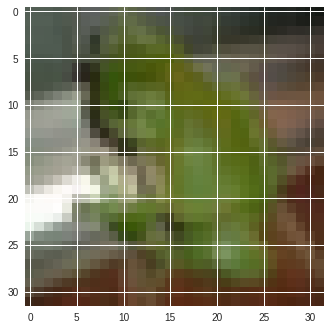

In [0]:
# display and predict firt test image 
imshow(testset[7][0])
testimg = np.asarray([X_test[7]])
predicted = nn_test.predict(testimg)
print("Predicted label: ", predicted)

Predicted label:  [0]


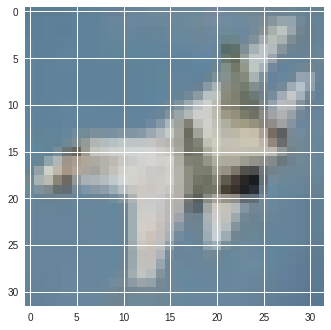

In [0]:
# display and predict second test image 
imshow(testset[10][0])
testimg = np.asarray([X_test[10]])
predicted = nn_test.predict(testimg)
print("Predicted label: ", predicted)

Predicted label:  [6]


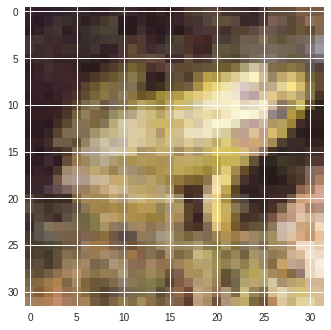

In [0]:
# display and predict third test image 
imshow(testset[19][0])
testimg = np.asarray([X_test[19]])
predicted = nn_test.predict(testimg)
print("Predicted label: ", predicted)

Predicted label:  [6]


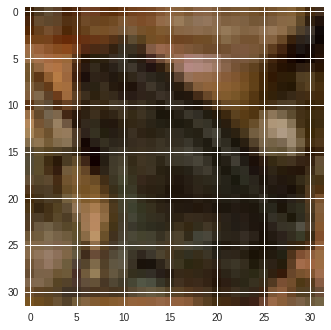

In [0]:
# display and predict fourth test image 
imshow(testset[30][0])
testimg = np.asarray([X_test[30]])
predicted = nn_test.predict(testimg)
print("Predicted label: ", predicted)

Predicted label:  [9]


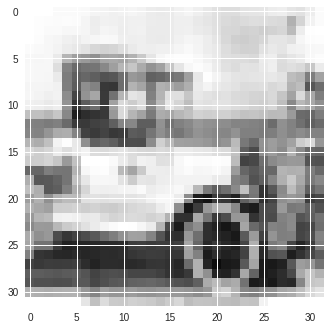

In [0]:
# display and predict fifth test image 
imshow(testset[37][0])
testimg = np.asarray([X_test[37]])
predicted = nn_test.predict(testimg)
print("Predicted label: ", predicted)

# 2. NN Using PyTorch

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## 2.1 Loading the CIFAR10 Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader, random_split
transform = transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_val_ratio = 0.9
n_train = int(len(trainset) * train_val_ratio)
n_val = len(trainset) - n_train
trainset, valset = random_split(trainset, [n_train, n_val])
trainloader = DataLoader(trainset, batch_size=50, num_workers=1, shuffle=True)
valloader = DataLoader(valset, batch_size=1000, num_workers=1, shuffle=False)
testloader = DataLoader(testset, batch_size=1000, num_workers=1, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## 2.2.1 Implementing the Network
First try a simple Convolutional Neural Network with 2 convolutional layers and 2 fully-connected layers

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # input is 32 by 32 with 3 channels
        # padding=2, same int used for height and width dimension
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)     
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*8*8, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = x.view(-1, 64*8*8) # reshape before sending to fc layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # default p=0.5
        x = self.fc2(x)
        return F.log_softmax(x)

### Define optimizer (loss is defined in the next cell)

In [0]:
model = Model()
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


### Train

In [0]:
batch_size = 50

# send model to GPU
model.cuda()


train_loss, train_accu = [], []
val_accu = []
i = 0
for epoch in range(15):
    model.train() # to set train mode for drop out
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model(images)             # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tTraining loss: {:.3f}\tTraining accuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1
    
    model.eval()
    correct = 0
    for images, labels in valloader:
        with torch.no_grad(): # so that computation graph history is not stored
            images, labels = images.cuda(), labels.cuda() # send tensors to GPU
            outputs = model(images)
            predictions = outputs.data.max(1)[1]
            correct += predictions.eq(labels.data).sum()
            
    print("===============================================")        
    print('Epoch %d' % (epoch + 1))    
    print('Validation accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))
    print("===============================================")
    val_accu.append(100.0 * correct / len(valloader.dataset))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Step: 0	Training loss: 2.328	Training accuracy: 8.000
Epoch 1
Validation accuracy: 61.00%
Train Step: 1000	Training loss: 1.115	Training accuracy: 58.000
Epoch 2
Validation accuracy: 65.00%
Train Step: 2000	Training loss: 0.872	Training accuracy: 70.000
Epoch 3
Validation accuracy: 70.00%
Train Step: 3000	Training loss: 0.739	Training accuracy: 76.000
Epoch 4
Validation accuracy: 72.00%
Train Step: 4000	Training loss: 0.598	Training accuracy: 76.000
Epoch 5
Validation accuracy: 72.00%
Train Step: 5000	Training loss: 0.551	Training accuracy: 82.000
Epoch 6
Validation accuracy: 75.00%
Train Step: 6000	Training loss: 0.532	Training accuracy: 78.000
Epoch 7
Validation accuracy: 74.00%
Train Step: 7000	Training loss: 0.255	Training accuracy: 90.000
Epoch 8
Validation accuracy: 76.00%
Train Step: 8000	Training loss: 0.307	Training accuracy: 92.000
Epoch 9
Validation accuracy: 76.00%
Epoch 10
Validation accuracy: 77.00%
Train Step: 9000	Training loss: 0.274	Training accuracy: 92.000
Epo

### Test

In [0]:
model.eval()
correct = 0
for images, labels in testloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        
print('Test set accuracy: {:.2f}%'.format(100.0 * correct / len(testloader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test set accuracy: 76.00%


## 2.2.2 Fine-tuning the Network
Fine-tuning the structure of the network to achieve a higher accuracy. Here, we use 3 convolutional layers instead of 2, use larger fully-connected layers. Additionally, we use ADAM instead of mini-batch Gradient Descent as the optimizer.

In [0]:
class Model1(nn.Module):
  
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 10)
    
    def forward(self, X):
        A1 = self.pool(F.relu(self.bn1(self.conv1(X))))
        A2 = self.pool(F.relu(self.bn2(self.conv2(A1))))
        A3 = self.pool(F.relu(self.bn3(self.conv3(A2))))
        flattened_A3 = A3.view(-1, 128 * 4 * 4) # flattening
        A4 = F.relu(self.fc1(flattened_A3))
        dropouted_A4 = F.dropout(A4, training=self.training)
        A5 = self.fc2(A4)
        return F.log_softmax(A5)

### Define optimizer (loss is defined in the next cell)

In [0]:
model = Model1()
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)

Model1(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)


### Train

In [0]:
batch_size = 50

# send model to GPU
model.cuda()


train_loss, train_accu = [], []
val_accu = []
i = 0
for epoch in range(15):
    model.train() # to set train mode for drop out
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model(images)             # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tTraining loss: {:.3f}\tTraining accuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1
        
    model.eval()
    correct = 0
    for images, labels in valloader:
        with torch.no_grad(): # so that computation graph history is not stored
            images, labels = images.cuda(), labels.cuda() # send tensors to GPU
            outputs = model(images)
            predictions = outputs.data.max(1)[1]
            correct += predictions.eq(labels.data).sum()
            
    print("===============================================")        
    print('Epoch %d' % (epoch + 1))    
    print('Validation accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))
    print("===============================================")
    val_accu.append(100.0 * correct / len(valloader.dataset))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Step: 0	Training loss: 2.332	Training accuracy: 8.000
Epoch 1
Validation accuracy: 64.00%
Train Step: 1000	Training loss: 1.124	Training accuracy: 62.000
Epoch 2
Validation accuracy: 71.00%
Train Step: 2000	Training loss: 0.966	Training accuracy: 66.000
Epoch 3
Validation accuracy: 74.00%
Train Step: 3000	Training loss: 0.710	Training accuracy: 66.000
Epoch 4
Validation accuracy: 75.00%
Train Step: 4000	Training loss: 0.393	Training accuracy: 86.000
Epoch 5
Validation accuracy: 77.00%
Train Step: 5000	Training loss: 0.584	Training accuracy: 82.000
Epoch 6
Validation accuracy: 77.00%
Train Step: 6000	Training loss: 0.509	Training accuracy: 82.000
Epoch 7
Validation accuracy: 78.00%
Train Step: 7000	Training loss: 0.373	Training accuracy: 90.000
Epoch 8
Validation accuracy: 75.00%
Train Step: 8000	Training loss: 0.175	Training accuracy: 94.000
Epoch 9
Validation accuracy: 77.00%
Epoch 10
Validation accuracy: 77.00%
Train Step: 9000	Training loss: 0.022	Training accuracy: 100.000
Ep

### Test

In [0]:
model.eval()
correct = 0
for images, labels in testloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        
print('Test set accuracy: {:.2f}%'.format(100.0 * correct / len(testloader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test set accuracy: 72.00%


In [0]:
class Model2(nn.Module):
  
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 10)
    
    def forward(self, X):
        A1 = self.pool(F.selu(self.bn1(self.conv1(X))))
        A2 = self.pool(F.selu(self.bn2(self.conv2(A1))))
        A3 = self.pool(F.selu(self.bn3(self.conv3(A2))))
        flattened_A3 = A3.view(-1, 128 * 4 * 4) # flattening
        A4 = F.relu(self.fc1(flattened_A3))
        dropouted_A4 = F.dropout(A4, training=self.training)
        A5 = self.fc2(A4)
        return F.log_softmax(A5)

### Define optimizer (loss is defined in the next cell)

In [0]:
model = Model2()
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

Model2(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


### Train

In [0]:
batch_size = 50

# send model to GPU
model.cuda()


train_loss, train_accu = [], []
val_accu = []
i = 0
for epoch in range(15):
    model.train() # to set train mode for drop out
    for images, labels in trainloader:
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model(images)             # calls the forward function of model, i.e. model.forward(images)
        loss = F.nll_loss(outputs, labels)  # calculate loss
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/batch_size*100
        train_accu.append(accuracy)
        if i % 1000 == 0:
            print('Train Step: {}\tTraining loss: {:.3f}\tTraining accuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1
        
    scheduler.step(train_loss[-1])
    model.eval()
    correct = 0
    for images, labels in valloader:
        with torch.no_grad(): # so that computation graph history is not stored
            images, labels = images.cuda(), labels.cuda() # send tensors to GPU
            outputs = model(images)
            predictions = outputs.data.max(1)[1]
            correct += predictions.eq(labels.data).sum()
            
    print("===============================================")        
    print('Epoch %d' % (epoch + 1))    
    print('Validation accuracy: {:.2f}%'.format(100.0 * correct / len(valloader.dataset)))
    print("===============================================")
    val_accu.append(100.0 * correct / len(valloader.dataset))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Step: 0	Training loss: 2.306	Training accuracy: 12.000
Epoch 1
Validation accuracy: 64.00%
Train Step: 1000	Training loss: 0.925	Training accuracy: 70.000
Epoch 2
Validation accuracy: 69.00%
Train Step: 2000	Training loss: 0.473	Training accuracy: 78.000
Epoch 3
Validation accuracy: 72.00%
Train Step: 3000	Training loss: 0.868	Training accuracy: 68.000
Epoch 4
Validation accuracy: 72.00%
Train Step: 4000	Training loss: 0.293	Training accuracy: 88.000
Epoch 5
Validation accuracy: 74.00%
Train Step: 5000	Training loss: 0.277	Training accuracy: 90.000
Epoch 6
Validation accuracy: 73.00%
Train Step: 6000	Training loss: 0.176	Training accuracy: 94.000
Epoch 7
Validation accuracy: 74.00%
Train Step: 7000	Training loss: 0.170	Training accuracy: 96.000
Epoch 8
Validation accuracy: 74.00%
Train Step: 8000	Training loss: 0.122	Training accuracy: 96.000
Epoch 9
Validation accuracy: 74.00%
Epoch 10
Validation accuracy: 73.00%
Train Step: 9000	Training loss: 0.026	Training accuracy: 100.000
E

### Test

In [0]:
model.eval()
correct = 0
for images, labels in testloader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.cuda(), labels.cuda() # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        
print('Test set accuracy: {:.2f}%'.format(100.0 * correct / len(testloader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test set accuracy: 72.00%


## **Discussion of Methods:**

1
Firstly, we implement a Convolutional Neural Network with two convolutional layers followed by two fully connected layers. The first convolutional layer is composed of 32 kernels, each kernel is of size 5*5, with padding of 2, and the second convolutional layer is composed of 64 kernels with the same size and padding. We did batch normalization and used ReLU as the activation function. The first fully connected layer has 1024 units and the second fully connected layer has 10 units. We used mini-batch gradient descent as the optimizer.

After 15 epochs of training, we reached a validation accuracy of around 77%, and a testing accuracy of 76%.
We observed that after epoch 5, the validation accuracy has been lower than the training accuracy significantly, so there    might be the situation of overfitting.

2
In the first attempt of tuning,  we changed into using three convolutional layers and two fully connected layers, and we changed the optimizer into Adam. The first convolutional layer is composed of 32 kernels, each kernel is of size 5*5, with padding of 2; the second convolutional layer is composed of 64 kernels, each kernel is of size 3*3, with padding of 1; the third convolutional layer is composed of 128 kernels. We did batch normalization and used ReLU as the activation function. The first fully connected layer has 1024 units and the second fully connected layer has 10 units. 

We also decrease the learning rate by a factor of 10 (i.e. 0.01 to 0.001) in attempt to yield a better accuracy. After epochs of training, we reached a validation accuracy of around 77%, and a testing accuracy of 72%. We observed that the overfitting problem seems to be more severe than the original model, maybe due to the number of parameters become relatively larger, but did not use more data.

3.
In the second attempt of tuning,  we reduced learning rate if the training loss does not reduce for 5 epoches in order to yield better result. Additionally, we also changed activation to SeLU for more non-linearity. However, the validation accuracy did not improve (reduced to 72%).

## 2.3 Predict Selected Images

In [0]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5# unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [0]:
testloader2 = DataLoader(testset, batch_size=1, shuffle=True)
testiter = iter(testloader2)

tensor([2], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


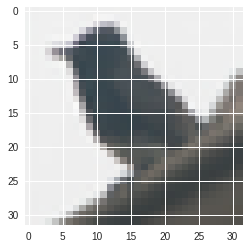

In [0]:
images, labels = next(testiter)
with torch.no_grad(): # so that computation graph history is not stored
    images, labels = images.cuda(), labels.cuda() # send tensors to GPU
    outputs = model(images)
    predictions = outputs.data.max(1)[1]
    print(predictions)
    imshow(torchvision.utils.make_grid(images.cpu()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([8], device='cuda:0')


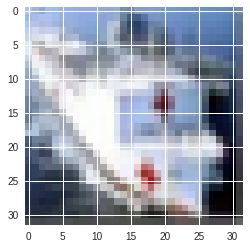

In [0]:
images, labels = next(testiter)
with torch.no_grad(): # so that computation graph history is not stored
    images, labels = images.cuda(), labels.cuda() # send tensors to GPU
    outputs = model(images)
    predictions = outputs.data.max(1)[1]
    print(predictions)
    imshow(torchvision.utils.make_grid(images.cpu()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([1], device='cuda:0')


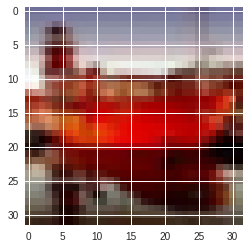

In [0]:
images, labels = next(testiter)
with torch.no_grad(): # so that computation graph history is not stored
    images, labels = images.cuda(), labels.cuda() # send tensors to GPU
    outputs = model(images)
    predictions = outputs.data.max(1)[1]
    print(predictions)
    imshow(torchvision.utils.make_grid(images.cpu()))

tensor([0], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


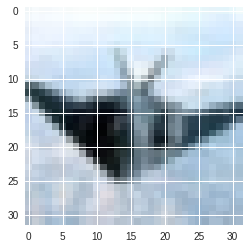

In [0]:
images, labels = next(testiter)
with torch.no_grad(): # so that computation graph history is not stored
    images, labels = images.cuda(), labels.cuda() # send tensors to GPU
    outputs = model(images)
    predictions = outputs.data.max(1)[1]
    print(predictions)
    imshow(torchvision.utils.make_grid(images.cpu()))

tensor([3], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


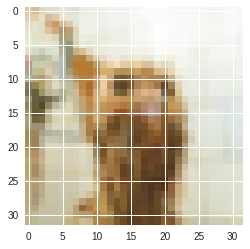

In [0]:
images, labels = next(testiter)
with torch.no_grad(): # so that computation graph history is not stored
    images, labels = images.cuda(), labels.cuda() # send tensors to GPU
    outputs = model(images)
    predictions = outputs.data.max(1)[1]
    print(predictions)
    imshow(torchvision.utils.make_grid(images.cpu()))